<a href="https://colab.research.google.com/github/reza-pishva/1-SchoolProject-Php-Laravel/blob/main/rnn5-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
import yfinance as yf
from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood
import pandas as pd
from datetime import datetime
import numpy as np

In [139]:
# Fetch MSFT stock data
msft = yf.Ticker('MSFT')
data = msft.history(start='2023-01-01', end='2024-06-01')
data.to_csv('msft_data.csv')
df2 = pd.read_csv('msft_data.csv')

In [140]:
df2

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-03 00:00:00-05:00,239.633899,242.266045,234.034415,236.183517,25740000,0.0,0.0
1,2023-01-04 00:00:00-05:00,228.987023,229.568655,222.756627,225.852112,50623400,0.0,0.0
2,2023-01-05 00:00:00-05:00,223.979031,224.324075,218.616150,219.158356,39585600,0.0,0.0
3,2023-01-06 00:00:00-05:00,219.838579,222.559446,216.240331,221.741211,43613600,0.0,0.0
4,2023-01-09 00:00:00-05:00,223.239662,227.961764,223.200236,223.900162,27369800,0.0,0.0
...,...,...,...,...,...,...,...,...
350,2024-05-24 00:00:00-04:00,426.421420,430.284453,423.646423,429.386078,11845800,0.0,0.0
351,2024-05-28 00:00:00-04:00,428.857015,430.044877,425.832468,429.545776,15718000,0.0,0.0
352,2024-05-29 00:00:00-04:00,424.924108,430.164662,424.924108,428.397858,15517100,0.0,0.0
353,2024-05-30 00:00:00-04:00,423.536599,423.536599,413.494701,413.923950,28424800,0.0,0.0


In [141]:
# Preprocess the data
df2['Date'] = pd.to_datetime(df2['Date'], utc=True)
df2['Date'] = df2['Date'].dt.tz_localize(None)
df2['Date'] = df2['Date'].dt.date
df2['Date'] = pd.to_datetime(df2['Date'])

<Axes: xlabel='Date'>

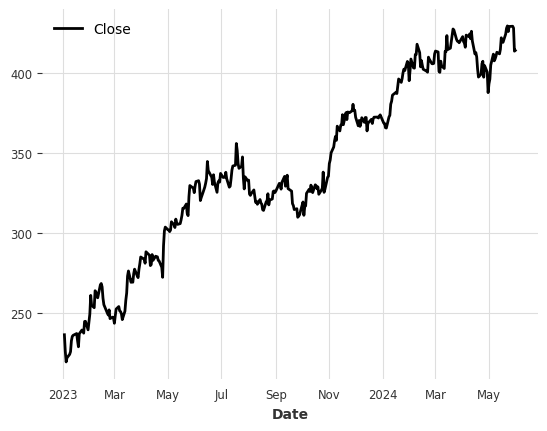

In [142]:
# Create a TimeSeries object and fill missing values
series = fill_missing_values(TimeSeries.from_dataframe(df2, time_col='Date', value_cols='Close', freq="D"), "auto", fill_missing_dates=True)
series.plot()

In [143]:
# Generate datetime attribute covariates
datetime_covariates = datetime_attribute_timeseries(series, attribute="day", one_hot=True)
datetime_covariates = datetime_covariates.stack(datetime_attribute_timeseries(series, attribute="month", one_hot=True))

In [144]:
# Extend the covariates to start from 2023-12-03
extended_covariates = datetime_covariates.slice(pd.Timestamp('2023-12-03'), pd.Timestamp('2024-06-01'))

In [145]:
# Initialize the Darts scaler
scaler = Scaler()
# Fit and transform the data
scaled_close_seies = scaler.fit_transform(series)
scaled_covariates = scaler.fit_transform(datetime_covariates)


In [146]:
# Split the dataset into training and test sets
train_ts, val_ts = scaled_close_seies.split_after(pd.Timestamp('2024-01-01'))
train_covariates, val_covariates = scaled_covariates.split_after(pd.Timestamp('2024-01-01'))

In [147]:
# Initialize the TFT model with future covariates
tft_model = TFTModel(
    input_chunk_length=30,
    output_chunk_length=7,
    hidden_size=16,
    lstm_layers=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=10,
    likelihood=GaussianLikelihood(),
    add_relative_index=True
)

In [148]:
# Fit the model on the training data
tft_model.fit(train_ts)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.2 K  | train
5  | decoder_vsn                       | _VariableSelectionNetwork   

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TFTModel(output_chunk_shift=0, hidden_size=16, lstm_layers=2, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=GaussianLikelihood(prior_mu=None, prior_sigma=None, prior_strength=1.0, beta_nll=0.0), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=30, output_chunk_length=7, batch_size=32, n_epochs=10)

In [149]:
len(val_ts)

151

In [150]:
# Make predictions on the test dataset
prediction = tft_model.predict(10)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [152]:
# Inverse transform the predictions (if needed)
inverted_prediction = scaler.inverse_transform(prediction)
inverted_prediction.plot()

ValueError: non-broadcastable output operand with shape (10,1) doesn't match the broadcast shape (10,43)

In [ ]:
# Calculate MAE and MAPE
mae = np.abs(val_ts.univariate_values() - inverted_prediction.univariate_values()).mean()
mape = (np.abs(val_ts.univariate_values() - inverted_prediction.univariate_values()) / val_ts.univariate_values()).mean() * 100

# Print the results
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")